In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

from itertools import product

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report


# Repeat the prior data mining example to identify the top 10 long/short trades
# using the last 10 years. But apply ML to determine whether we should actually
# take up those trades proposed by the seasonal strategy. In this case,
# conditional on a signal, assign a 1 or 0 if the strategy would have yielded
# a return of at least 1% (to roughly account for slippage or bid/ask spread)
# and use a random forest to predict, based off of a number of indicators:
# 1) Other seasonal indicators: Winrate for last year, last 3 yrs, last 5 yrs
# 2) Estimate of daily volatility (EWM with span parameter = 30)
# 3) Simple momentum indicator for the stock and the SP500 overall: 'up'
#    if EWM with span of 5 (1 week) exceeds the EWM with span of 10 (2 weeks)
# 4) Returns relative to yesterday's price, for stock and SP500 overall

def seasonal_return(data, symbol, start_date, end_date, first_year, last_year):
    data_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year + 1)):
        full_start_date = str(year) + '-' + start_date
        full_end_date = str(year) + '-' + end_date
        trade_start_date = data.loc[full_start_date, 'Price Date']
        trade_end_date = data.loc[full_end_date, 'Price Date']
        start_price = data.loc[full_start_date, symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date, symbol]
        if np.isnan(end_price):
            continue
        returns = np.log(end_price / start_price)
        data_list.append([symbol, year, trade_start_date, start_price,
                          trade_end_date,
                          end_price, returns])

    df = pd.DataFrame(data_list, columns=['Symbol', 'Year', 'Init Date',
        'Init Price', 'Final Date', 'Final Price', 'Return'])
    return df


def return_stats(x, risk_free_rate=0):
    d = {}
    d['N'] = x['Symbol'].count()
    d['avg r'] = x['Return'].mean()
    d['vol'] = x['Return'].std()
    downsides = x[x['Return'] < risk_free_rate]['Return']
    d['downside dev'] = 0 if downsides.count() == 0 else downsides.std()
    upsides = x[-x['Return'] < risk_free_rate]['Return']
    d['upside dev'] = 0 if upsides.count() == 0 else upsides.std()
    d['up'] = sum(x['Return'] > risk_free_rate)
    return pd.Series(d, index=['N', 'avg r', 'vol', 'downside dev',
        'upside dev', 'up'])


# Historical rate of stock going up (i.e. winrate if we are long)
def historical_up_rate(data, symbol, start_date, end_date, first_year, last_year):
    up_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year + 1)):
        full_start_date = str(year) + '-' + start_date
        full_end_date = str(year) + '-' + end_date
        trade_start_date = data.loc[full_start_date, 'Price Date']
        trade_end_date = data.loc[full_end_date, 'Price Date']
        start_price = data.loc[full_start_date, symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date, symbol]
        if np.isnan(end_price):
            continue

        if end_price >= start_price:
            ret = 1
        else:
            ret = 0
        up_list.append(ret)
    return np.mean(up_list)

/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Pull the adjusted close prices off Yahoo Finance
df = pd.read_csv("S&P500-Symbols.csv")
tickers = list(df['Symbol'])
start_date = '1989-01-01'
end_date = '2024-01-03'  # Get data a few days past end of year to backfill

# Either pull from Yahoo finance, or for read the pre-downloaded CSV
# data = pd.DataFrame(yf.download(tickers, start_date, end_date)['Adj Close'])
# data.reset_index().to_csv("S&P500-adjusted-close.csv", index=False)
data = pd.read_csv('S&P500-adjusted-close.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
all_dates = pd.date_range(start_date, end_date)
data['Price Date'] = data.index

# Backfill with trading prices for missing dates
data = data.reindex(all_dates, method='bfill')
sp500_dates_added = pd.read_csv("S&P500-Info.csv")[['Symbol', 'Date added']]
all_stocks = data.columns.drop(labels='Price Date')
data = data[data.index < '2024-01-01']

# Restrict to stocks that have data back in 2009, total of 432
sub_cols = data.columns[data.loc['2009-01-01'].notna()]
sub_cols = sub_cols.append(pd.Index(['Price Date']))
sub_stocks = data[sub_cols].columns.drop(labels='Price Date')
sub_data = data[sub_cols][data.index >= '2009-01-01']

# Specifications for the technical strategy
hold_range = [7, 14, 28]  # hold for 1, 2, or 4 weeks
delay_range = [0, 5, 10]  # search for trades 0, 5, 10 days after trade window

# Trade windows start on the 1st/15th of each month
start_months = list(range(1, 12 + 1))
start_days = ['-01', '-15']
initial_dates = [str(i) + j for i, j in product(start_months, start_days)]

In [5]:
# Running the below loop for 2019, 2020, 2021 start/middle of months takes about an hour
# The results are saved in the CSV, so just load that instead

all_returns_list = []

for trade_year in [2019, 2020, 2021]:
    start_year = trade_year - 10
    end_year = trade_year - 1

    for initial_date in initial_dates:
        initial_calendar_year = datetime.strptime(
            str(trade_year) + "-" + initial_date, "%Y-%m-%d")

        # Delay refers to how many days after the 1st or 15th we start the trade
        for delay in delay_range:
            start_calendar_year = initial_calendar_year + timedelta(days=delay)
            start_calendar = start_calendar_year.strftime('%m-%d')

            for hold_length in hold_range:
                end_calendar = (start_calendar_year + timedelta(days=hold_length)
                                ).strftime('%m-%d')
                stock_returns_list = []

                for stock in sub_stocks:
                    stock_returns_list.append(seasonal_return(
                        sub_data, stock,start_calendar, end_calendar,
                        start_year, end_year))

                seasonal_returns = pd.concat(stock_returns_list)
                symbol_stats = seasonal_returns.groupby('Symbol').apply(
                    return_stats, risk_free_rate=0)
                symbol_stats['trade window'] = initial_calendar_year.strftime(
                    '%Y-%m-%d')
                symbol_stats['start date'] = start_calendar_year
                symbol_stats['end date'] = end_calendar
                symbol_stats['Sharpe Long'] = (symbol_stats['avg r']/
                    symbol_stats['vol'])
                symbol_stats['Sharpe Short'] = -(symbol_stats['avg r']/
                    symbol_stats['vol'])
                symbol_stats['hold length'] = hold_length
                all_returns_list.append(symbol_stats)

all_returns = pd.concat(all_returns_list)
# all_returns.to_csv('seasonal_trades_2019_2021.csv')

In [3]:
# Import the CSV of all returns
all_returns = pd.read_csv('seasonal_trades_2019_2021.csv')

# Annualize returns, extract
all_returns['annualized r'] = (all_returns['avg r'] * 365 /
                               all_returns['hold length'])
all_returns['trade year'] = all_returns['trade window'].str.slice(0, 4)

# Part 2: Generate features at the time of trade

We select the candidate seasonal trades, which have an annualized return > 50%, 6/10+ winrate in the last 10 years, and total return of at least 1%. Sort by highest Sharpe ratio using historical seasonal trades, and select the top 10 for each trade window.

Recall the features are
1) past year, past 3 years', past 5 years' winrate (up/down return ratio)
2) exponentially weighted daily volatility for both the stock and the SP500 (high volatility may make technical trades unattractive, since it may suggest the presence of other factors in price movements. And volatility spikes may indicate large stock movements downward)
3) the ratio of the exponentially weighted moving average centered around the last week (5 days) vs last two weeks (10 days) for the stock and SP500, indicating a form of near-term momentum
4) yesterday's returns for the stock and SP500

Also compute the actual returns for each seasonal trade.

In [4]:
# Select the top 10 trades per trade window, meeting the criteria
long_positions = all_returns[(all_returns['annualized r'] > 0.4) & 
(all_returns.up >= 6) & (all_returns['avg r'] > .015)].sort_values(
    'Sharpe Long', ascending=False).groupby('trade window').head(10)

# Define the feature functions

# Historical winrates
long_positions['past1yr'] = long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'], row['start date'][5:10], row['end date'],
    int(row['trade year']) - 1, int(row['trade year']) - 1), axis=1)

long_positions['past3yr'] = long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'], row['start date'][5:10], row['end date'],
    int(row['trade year']) - 3, int(row['trade year']) - 1), axis=1)

long_positions['past5yr'] = long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'], row['start date'][5:10], row['end date'],
    int(row['trade year']) - 5, int(row['trade year']) - 1), axis=1)

# Daily volatility with exponentially weighted moving average
# We get in a bit of trouble with the backfilled data: it would result in
# repetitions of the same price over non-trading days, reducing volatility,
# so move forward to the day we would trade and use non-backfilled data

data_no_backfill = data[data.index == data['Price Date']]

# Note that these functions are shifted by 1 day backwards, to avoid knowing the
# current day's closing price when making a trade decision during the day

def get_ewm_vol(data, symbol, date, span=10):
    stock_rets = np.log(data[symbol] / data[symbol].shift(1)).shift(1)
    return stock_rets.ewm(span).std().loc[date]


long_positions['ewm_vol'] = long_positions.apply(lambda row: get_ewm_vol(
    data_no_backfill, row['Symbol'], data.loc[row['start date']]['Price Date'],
    30), axis=1)

# EWMA of price: compare between a long/short window to determine
# whether the signal is long
def get_ewm_momentum(data, symbol, date, long_window, short_window):
    short_ewma = data[symbol].ewm(short_window).mean().shift(1).loc[date]
    long_ewma = data[symbol].ewm(long_window).mean().shift(1).loc[date]
    return np.log(short_ewma / long_ewma)

long_positions['long_momentum'] = long_positions.apply(
    lambda row: get_ewm_momentum(data_no_backfill, row['Symbol'],
        data.loc[row['start date']]['Price Date'],
        long_window=10, short_window=5), axis=1)

# Generates an X-day back return. With days_back = 1, it is yesterday's observed
# return

def get_recent_return(data, symbol, date, days_back=1):
    return np.log(data[symbol]/data[symbol].shift(days_back)).shift(1).loc[date]

long_positions['yesterday_ret'] = long_positions.apply(
    lambda row: get_recent_return(data_no_backfill, row['Symbol'],
                                  data.loc[row['start date']]['Price Date'],
                                  days_back=1), axis=1)

# Get SP500 EWM vol/average ratio and yesterday returns, making sure not to backfill

spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])
all_dates = pd.date_range(start_date, end_date)

long_positions['sp500_ewm_vol'] = long_positions.apply(
    lambda row: get_ewm_vol(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'],10), axis=1)

long_positions['sp500_ewma'] = long_positions.apply(
    lambda row: get_ewm_momentum(spx, 'Adj Close',
     data.loc[row['start date']]['Price Date'], 
     long_window=10, short_window=5), axis=1)

long_positions['sp500_yest_ret'] = long_positions.apply(
    lambda row: get_recent_return(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'],
        days_back=1), axis=1)

[*********************100%%**********************]  1 of 1 completed


# Part 3: Random Forest on Seasonal Trades

Classify the actual returns into 1 or 0: a 1 if the actual return exceeds 2%, 0 otherwise. The choice of 2% is so that it is clear it is a winning trade. Given that many stocks have daily volatilities of around 1%, a smaller actual return (e.g. just 1%) would be us overlaying an ML model on what is largely noise. After defining our classifier, fit a random forest model on our training data set.

In [106]:
# Get the actual returns for the start/end date

def get_actual_return(data, symbol, start_date, end_date):
    return np.log(data[symbol].loc[end_date]/data[symbol].loc[start_date])

long_positions['actual_return'] = long_positions.apply(lambda row:
    get_actual_return(data, row['Symbol'], row['start date'],
        row['trade year']+'-'+row['end date']), axis = 1)

# 280/720 long trades would have absolute returns over 2%,
# i.e. ~39% of the trades
long_positions['outcome'] = np.where(
    long_positions['actual_return'] > 0.02, 1, 0)

# Implement Random Forest
X = long_positions[['past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y = long_positions['outcome'].values

# Split data into training/testing sets
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, range(len(y)), train_size=0.75, shuffle=False, random_state = np.random.seed(5555))

model = RandomForestClassifier(random_state = np.random.seed(5555))

model.fit(X_train,y_train)

RandomForestClassifier()

Generate a ROC curve as well as some classification reports. For the ROC curve, the general goal is to maximize the area under the curve, and to have the curve above the line y=x (which would be the outcome of a coin flip).

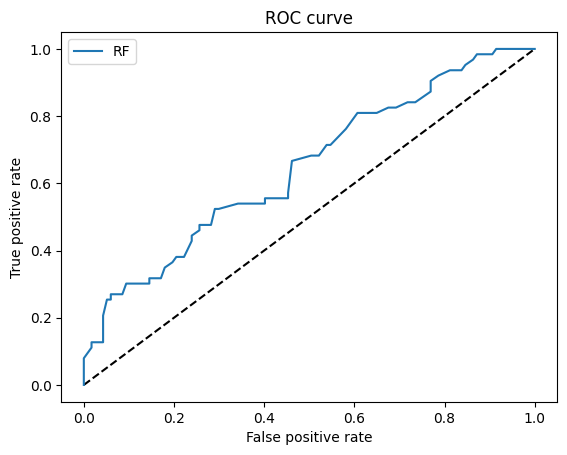

              precision    recall  f1-score   support

    no_trade       0.70      0.79      0.74       117
       trade       0.49      0.38      0.43        63

    accuracy                           0.64       180
   macro avg       0.60      0.58      0.59       180
weighted avg       0.63      0.64      0.63       180



KeyError: "None of [Index([540, 541, 542, 543, 544, 545, 546, 547, 548, 549,\n       ...\n       710, 711, 712, 713, 714, 715, 716, 717, 718, 719],\n      dtype='int64', length=180)] are in the [columns]"

In [108]:
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_test, y_pred,
                            target_names=['no_trade', 'trade']))
print('average return in all trades: %5.3f' % long_positions[indices_test]['actual_return'].mean())
print('average return in just RF trades: %5.3f' % long_positions[indices_test][y_pred==1]['actual_return'].mean())

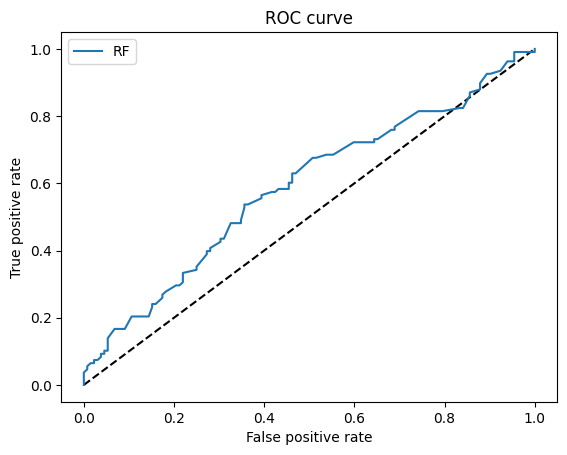

              precision    recall  f1-score   support

    no_trade       0.57      0.88      0.69       132
       trade       0.58      0.20      0.30       108

    accuracy                           0.57       240
   macro avg       0.58      0.54      0.50       240
weighted avg       0.58      0.57      0.52       240



In [75]:
long_positions['trade window date'] = pd.to_datetime(long_positions['trade window'])

a1 = pd.to_datetime('2019-01-01')
a2 = pd.to_datetime('2019-04-15')
b1 = pd.to_datetime('2020-05-01')
b2 = pd.to_datetime('2020-08-15')
c1 = pd.to_datetime('2021-09-01')
c2 = pd.to_datetime('2021-12-15')

test_flag = (((long_positions['trade window date'] >= a1) & (long_positions['trade window date'] <= a2)) |
 ((long_positions['trade window date'] >= b1) & (long_positions['trade window date'] <= b2)) |
 ((long_positions['trade window date'] >= c1) & (long_positions['trade window date'] <= c2)))

train_flag = ~test_flag
train_set = long_positions[train_flag]
test_set = long_positions[test_flag]

X_train = train_set[['past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y_train = train_set['outcome'].values

X_test = test_set[['past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y_test = test_set['outcome'].values

model = RandomForestClassifier(random_state = np.random.seed(5555))

model.fit(X_train,y_train)

y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_test, y_pred,
                            target_names=['no_trade', 'trade']))

In [74]:
y_train.sum()

172

Looking at the differences in the two classification reports, we see that the random forest improves precision for trades (the ratio of true positives divided by classified positives) from 0.35 when we would have taken every seasonal trade recommendation, to 0.49 when we use the classifier.

Precision is the metric we care the most about, since we "lose nothing" by not participating in a trade, and can always scale up the sizes of our trades to account for the fewer total number of trades we make. The seasonal strategy provides 10 trades every two weeks, meaning there is generally no shortage of trade opportunities (or we could scale up to more than the top 10 trades by Sharpe ratio).

# Part 4: Applying the model out of sample

Let's see what happens when we apply this model to 2022 and 2023. The below code generates the relevant datasets up to 2023, and is mostly a repeat of the earlier code for 2019-2021.

In [90]:
# DO NOT RUN the below, and instead read the CSV file
later_returns_list = []

for trade_year in [2022, 2023]:
    start_year = trade_year - 10
    end_year = trade_year - 1

    for initial_date in initial_dates:
        initial_calendar_year = datetime.strptime(
            str(trade_year) + "-" + initial_date, "%Y-%m-%d")

        # Delay refers to how many days after the 1st or 15th we start the trade
        for delay in delay_range:
            start_calendar_year = initial_calendar_year + timedelta(days=delay)
            start_calendar = start_calendar_year.strftime('%m-%d')

            for hold_length in hold_range:
                end_calendar = (start_calendar_year + timedelta(days=hold_length)
                                ).strftime('%m-%d')
                stock_returns_list = []

                for stock in sub_stocks:
                    stock_returns_list.append(seasonal_return(
                        sub_data, stock,start_calendar, end_calendar,
                        start_year, end_year))

                seasonal_returns = pd.concat(stock_returns_list)
                symbol_stats = seasonal_returns.groupby('Symbol').apply(
                    return_stats, risk_free_rate=0)
                symbol_stats['trade window'] = initial_calendar_year.strftime(
                    '%Y-%m-%d')
                symbol_stats['start date'] = start_calendar_year
                symbol_stats['end date'] = end_calendar
                symbol_stats['Sharpe Long'] = (symbol_stats['avg r']/
                    symbol_stats['vol'])
                symbol_stats['Sharpe Short'] = -(symbol_stats['avg r']/
                    symbol_stats['vol'])
                symbol_stats['hold length'] = hold_length
                later_returns_list.append(symbol_stats)


later_returns = pd.concat(later_returns_list)

# Annualize returns
later_returns['annualized r'] = (later_returns['avg r'] * 365 /
                                 later_returns['hold length'])
later_returns['trade year']=later_returns['trade window'].str.slice(0,4)

# later_returns.to_csv('seasonal_trades_2022_2023.csv')

In [88]:
# Read in seasonal long trades identified for 2022/2023 from CSV
later_returns = pd.read_csv('seasonal_trades_2022_2023.csv')

later_long_positions = later_returns[(later_returns['annualized r'] > 0.4) &
                                     (later_returns.up >= 6) & later_returns['avg r'] > .015].sort_values(
    'Sharpe Long', ascending=False).groupby('trade window').head(10)

# Calculate the feature values
later_long_positions['past3yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-3,int(row['trade year'])-1), axis = 1)

later_long_positions['past5yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-5,int(row['trade year'])-1), axis = 1)

later_long_positions['ewm_vol'] = later_long_positions.apply(
    lambda row: get_ewm_vol(data, row['Symbol'], row['start date'], 30), axis=1)

later_long_positions['long_momentum'] = later_long_positions.apply(
    lambda row: get_ewm_momentum(data, row['Symbol'], row['start date'],
        long_window=10, short_window=5), axis=1)

later_long_positions['yesterday_ret'] = later_long_positions.apply(
    lambda row: get_recent_return(data_no_backfill, row['Symbol'],
                                  data.loc[row['start date']]['Price Date'],
                                  days_back=1), axis=1)

later_long_positions['sp500_ewm_vol'] = later_long_positions.apply(
    lambda row: get_ewm_vol(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'], 10), axis=1)

later_long_positions['sp500_ewma'] = later_long_positions.apply(
    lambda row: get_ewm_momentum(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'], long_window=10,
        short_window=5), axis=1)

later_long_positions['sp500_yest_ret'] = later_long_positions.apply(
    lambda row: get_recent_return(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'], days_back=1), axis=1)

later_long_positions['actual_return'] = later_long_positions.apply(
    lambda row: get_actual_return(data, row['Symbol'], row['start date'],
        str(row['trade year']) + '-' + row['end date']), axis=1)

### Fit the model on all of X and y (data from 2019-2021), to predict for 2022


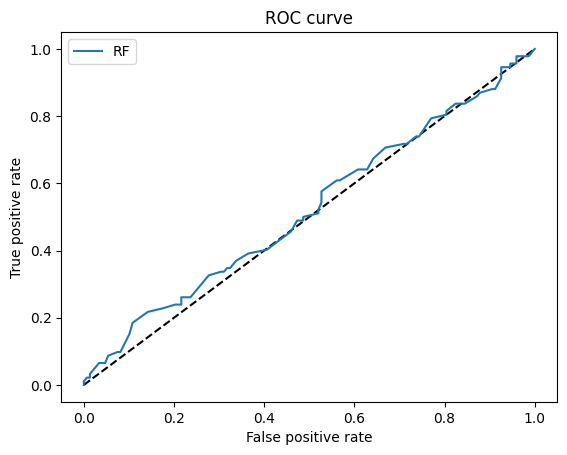

              precision    recall  f1-score   support

    no_trade       0.62      0.54      0.58       148
       trade       0.38      0.46      0.42        92

    accuracy                           0.51       240
   macro avg       0.50      0.50      0.50       240
weighted avg       0.53      0.51      0.51       240



0.38333333333333336

In [91]:
model = RandomForestClassifier(random_state = np.random.seed(5555))
model.fit(X, y)

long_2022 = later_long_positions[later_long_positions['trade year'] == 2022]
X_2022 = long_2022[['past3yr', 'past5yr','ewm_vol', 'long_momentum',
                    'yesterday_ret','sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y_2022 = np.where(long_2022['actual_return'] > 0.02, 1, 0)

rf_trade_2022_prob = model.predict_proba(X_2022)[:, 1]
rf_trade_2022 = model.predict(X_2022)
fpr_rf, tpr_rf, _ = roc_curve(y_2022, rf_trade_2022_prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


print(classification_report(y_2022, rf_trade_2022,
                            target_names=['no_trade', 'trade']))

y_2022.mean() # 38.3% of all trades in 2022,
#y_2022[rf_trade_2022==1].mean()


# long_2022['actual_return'].mean()
# long_2022[rf_trade_2022==1]['actual_return'].mean()

This model results in almost no change in overall precision of trades (taking all trades, compared to just those indicated by the random forest also has a 38% rate of returns of at least 2%), but a slightly and a statistically insignificant increase in average returns (0.22% to 0.26%, with a std dev of returns between 7.0-7.4%).

For 2023, add the data from 2019-2021 to that from 2022 to generate the set of training data ("to 2023") which will be used to motivate 2023 trades.

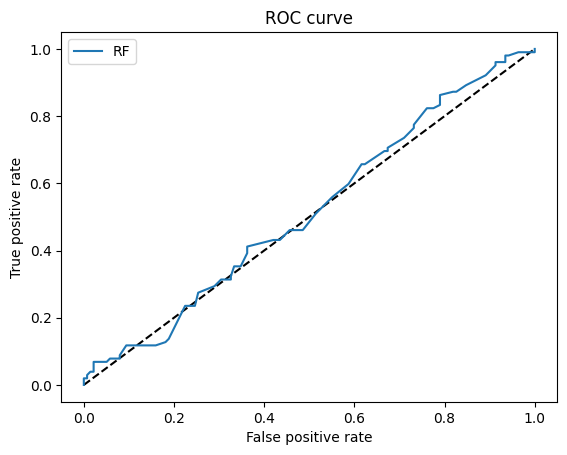

              precision    recall  f1-score   support

    no_trade       0.58      0.90      0.70       138
       trade       0.46      0.12      0.19       102

    accuracy                           0.57       240
   macro avg       0.52      0.51      0.45       240
weighted avg       0.53      0.57      0.48       240

                precision    recall  f1-score   support

no_trade_no_ML       0.00      0.00      0.00       138
   trade_no_ML       0.42      1.00      0.60       102

      accuracy                           0.42       240
     macro avg       0.21      0.50      0.30       240
  weighted avg       0.18      0.42      0.25       240



/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [97]:
# Repeat for 2023, using as training data from 2019-2022
long_positions_to_2023 = pd.concat([long_positions,
    later_long_positions[later_long_positions['trade year'] == 2022]])
long_positions_to_2023['outcome'] = np.where(
    long_positions_to_2023['actual_return'] > 0.02, 1, 0)

X_to_2023 = long_positions_to_2023[['past3yr', 'past5yr', 'ewm_vol',
'long_momentum', 'yesterday_ret','sp500_ewm_vol', 'sp500_ewma',
'sp500_yest_ret']].values
y_to_2023 = long_positions_to_2023['outcome'].values

model = RandomForestClassifier(random_state = np.random.seed(5555))
model.fit(X_to_2023, y_to_2023)

# Predict 2023 outcomes
long_2023 = later_long_positions[later_long_positions['trade year']== 2023]
X_2023 = long_2023[['past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol','sp500_ewma',
                    'sp500_yest_ret']].values
y_2023 = np.where(long_2023['actual_return'] > 0.02, 1, 0)

rf_trade_2023_prob = model.predict_proba(X_2023)[:, 1]
rf_trade_2023 = model.predict(X_2023)
fpr_rf, tpr_rf, _ = roc_curve(y_2023, rf_trade_2023_prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_2023, rf_trade_2023,
                            target_names=['no_trade', 'trade']))

print(classification_report(y_2023, np.repeat(1, len(y_2023)),
                            target_names=['no_trade_no_ML', 'trade_no_ML']))

# long_2023['actual_return'].mean()
# long_2023[rf_trade_2023==1]['actual_return'].count()

In [100]:
print(long_2023['actual_return'].mean())
print(long_2023[rf_trade_2023==1]['actual_return'].mean())

0.015262930525362213
0.021956645169033166


In [134]:
later_long_positions['ewm_vol'].mean()

0.015430608287351218

In [51]:
long_positions

,Symbol,N,avg r,vol,downside dev,upside dev,up,trade window,start date,end date,...,past3yr,past5yr,ewm_vol,long_momentum,yesterday_ret,sp500_ewm_vol,sp500_ewma,sp500_yest_ret,actual_return,outcome
72895,PNW,10.0,0.021772,0.006862,0.000000,0.006862,10.0,2019-10-01,2019-10-11,10-18,...,1.000000,1.0,0.009065,0.002099,-0.000419,0.009732,-0.003224,0.006395,-0.016370,0
232876,AMZN,10.0,0.072826,0.024648,0.000000,0.024648,10.0,2021-06-15,2021-06-25,07-23,...,1.000000,1.0,0.013112,0.015214,-0.015746,0.006743,0.003095,0.005794,0.072340,1
166313,XEL,10.0,0.015564,0.005423,0.000000,0.005423,10.0,2020-10-01,2020-10-11,10-18,...,1.000000,1.0,0.015255,0.012106,0.002754,0.012643,0.004678,0.008755,-0.026565,0
196065,TDY,10.0,0.026857,0.009499,0.000000,0.009499,10.0,2021-02-01,2021-02-06,02-13,...,1.000000,1.0,0.023035,0.000586,-0.005902,0.010930,0.005587,0.003890,0.008515,0
134873,CNC,10.0,0.030123,0.011196,0.000000,0.011196,10.0,2020-06-01,2020-06-11,06-18,...,1.000000,1.0,0.035309,-0.002169,-0.019373,0.013713,0.023285,-0.005327,0.059433,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256333,FDX,10.0,0.065254,0.078865,0.048400,0.051801,8.0,2021-09-15,2021-09-25,10-23,...,0.666667,0.6,0.020149,-0.033043,-0.010010,0.007709,-0.002492,0.001460,0.038497,1
256221,BALL,10.0,0.044279,0.053597,0.019598,0.046962,8.0,2021-09-15,2021-09-25,10-23,...,0.666667,0.8,0.011893,0.001228,-0.010240,0.007709,-0.002492,0.001460,-0.037469,0
205817,HES,10.0,0.045769,0.056711,NaN,0.030604,9.0,2021-03-01,2021-03-11,04-08,...,1.000000,1.0,0.033306,0.039124,0.005516,0.012278,0.000005,0.006012,0.006777,0
205993,STZ,10.0,0.054573,0.067898,0.017574,0.047788,7.0,2021-03-01,2021-03-11,04-08,...,0.666667,0.8,0.018584,-0.001901,-0.000176,0.012278,0.000005,0.006012,-0.019435,0


In [50]:
data.loc['2023-06-25']['Price Date']

Timestamp('2023-06-26 00:00:00')

,Symbol,N,avg r,vol,downside dev,upside dev,up,trade window,start date,end date,...,past1yr,past3yr,past5yr,ewm_vol,long_momentum,yesterday_ret,sp500_ewm_vol,sp500_ewma,sp500_yest_ret,actual_return
outcome,,,,,,,,,,,,,,,,,,,,,
0,500,500,500,500,293,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
1,220,220,220,220,131,220,220,220,220,220,...,220,220,220,220,220,220,220,220,220,220


In [29]:
train_indices = (f(long_positions['trade window date']) >=pd('2019-01-01') &
                 f(long_positions['trade window date']) <= f('2019-04-01'))

TypeError: unsupported operand type(s) for &: 'Timestamp' and 'DatetimeArray'

In [162]:
long_2022['actual_return'].std()
#long_2022[rf_trade_2022==1]['actual_return'].std()

0.07073741209138709

72895      True
232876    False
166313    False
196065    False
134873    False
          ...  
256491    False
205772    False
198797    False
201256    False
198492    False
Name: trade window date, Length: 720, dtype: bool

[540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 638,
 639,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 654,
 655,
 656,
 657,
 658,
 659,
 660,
 661,
 662,
 663,
 664,
 665,
 666,
 667,
 668,
 669,
 670,
 671,
 672,
 673,
 674,
 675,
 676,
 677,
 678,
 679,
 680,
 681,
 682,
 683,
 684,
 685,
 686,
 687,
 688,
 689,
 690,
 691,
 692,
 693,
 694,
 695,
 696,
 697,
 698,
 699,
 700,
 701,
 702,
 703,
 704,
 705,
 706